# Optimizer

## LandUse optimizer

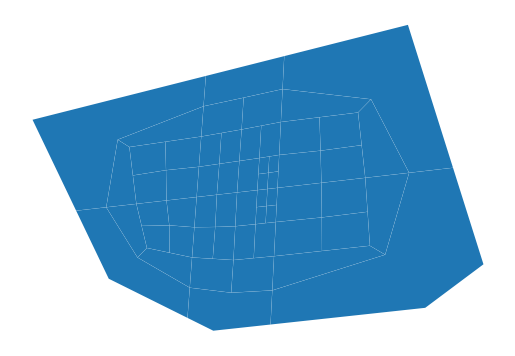

In [1]:
import geopandas as gpd

blocks_gdf = gpd.read_file('sveto.geojson')[['geometry']]
blocks_gdf.geometry = blocks_gdf.buffer(-0.5)
blocks_gdf = gpd.GeoDataFrame(blocks_gdf.geometry.explode(True)).reset_index(drop=True)
blocks_gdf.plot().set_axis_off()

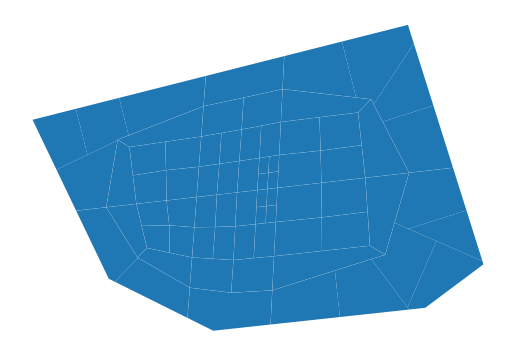

In [2]:
from blocksnet.preprocessing import LandUseOptimizer
import networkx as nx

luo = LandUseOptimizer(blocks_gdf)
luo.blocks.plot().set_axis_off()

In [3]:
from blocksnet import LandUse

lu_shares = {
  LandUse.RESIDENTIAL: 0.3,
  LandUse.BUSINESS: 0.2,
  LandUse.RECREATION: 0.2,
  LandUse.SPECIAL: 0.05,
  LandUse.INDUSTRIAL: 0.05,
  LandUse.AGRICULTURE: 0.1,
  LandUse.TRANSPORT: 0.1
}

best_X, best_value, Xs, values = luo.run(lu_shares, rate=0.999, max_iter=100_000)

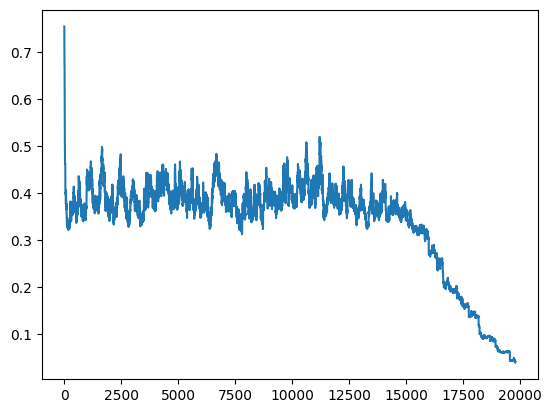

In [4]:
import matplotlib.pyplot as plt

plt.plot(values)

In [5]:
best_value

0.0387775760914957

In [6]:
luo.to_shares_dict(best_X)

{<LandUse.RESIDENTIAL: 'residential'>: 0.32908955381853383,
 <LandUse.BUSINESS: 'business'>: 0.12946045909227957,
 <LandUse.RECREATION: 'recreation'>: 0.2747700327450179,
 <LandUse.SPECIAL: 'special'>: 0.08145084153401719,
 <LandUse.INDUSTRIAL: 'industrial'>: 0.054873320123344387,
 <LandUse.AGRICULTURE: 'agriculture'>: 0.060598011135111304,
 <LandUse.TRANSPORT: 'transport'>: 0.06975778155169603}

In [7]:
# data = [{lu.value : share for lu,share in luo.to_shares_dict(X).items()} for X in Xs]

In [8]:
# import pandas as pd

# df = pd.DataFrame(data)
# df.plot(kind='area', stacked=True, figsize=(10,10))

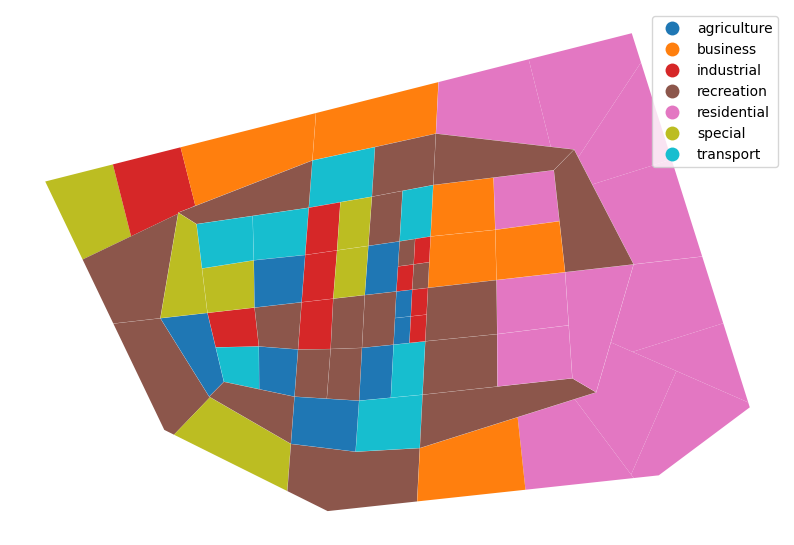

In [9]:
luo.to_gdf(best_X).plot(column='land_use', legend=True, figsize=(10,10)).set_axis_off()

In [10]:
all(luo.blocks.area>=2_000)

False

## Services optimizer

In [11]:
import networkx as nx
from blocksnet import AccessibilityProcessor
from shapely import length, LineString, Point

SPEED = 10 * 1000 / 60

graph = luo.adjacency_graph.copy()
graph.graph['crs'] = luo.blocks.crs.to_epsg()
for node, data in graph.nodes(data=True):
  point = luo.blocks.loc[node,'geometry'].representative_point()
  data['geometry'] = point
  data['x'] = point.x
  data['y'] = point.y
for u, v, data in graph.edges(data=True):
  point_u = graph.nodes[u]['geometry']
  point_v = graph.nodes[v]['geometry']
  line_string = LineString([point_u, point_v])
  data['time_min'] = length(line_string)/SPEED

ap = AccessibilityProcessor(luo.blocks)
acc_mx = ap.get_accessibility_matrix(graph)

In [12]:
from blocksnet import City

city = City(luo.to_gdf(best_X), acc_mx)

In [13]:
from blocksnet.method.annealing_optimizer import AnnealingOptimizer, LU_FSIS, LU_GSIS

blocks_lu = {block.id : best_X[block.id] for block in city.blocks}
blocks_fsi = {b_id : LU_FSIS[lu][0] for b_id, lu in blocks_lu.items()}
blocks_gsi = {b_id : LU_GSIS[lu][0] for b_id, lu in blocks_lu.items()}
service_types = {service_type.name : 1/len(city.service_types) for service_type in city.service_types}

# st_names = ['school', 'pharmacy', 'kindergarten', 'park']
# service_types = {st:1/len(st_names) for st in st_names}

values = []

def on_iteration(i, X, indicators, value):
    values.append(value)

ao = AnnealingOptimizer(city_model=city, on_iteration=on_iteration, verbose=True)
X, indicators, value, provisions = ao.calculate(blocks_lu, blocks_fsi, blocks_gsi, service_types, rate=0.999, max_iter=100_000)

plt.plot(values)

Best value : 0.75:   6%|▌         | 6138/100000 [03:05<46:01, 33.99it/s]                

KeyboardInterrupt: 

Best value : 0.75:   6%|▌         | 6138/100000 [03:20<46:01, 33.99it/s]

In [67]:
provisions

{'school': 1.0,
 'pharmacy': 1.0,
 'kindergarten': 0.975753742357158,
 'park': 0.0,
 'hospital': 1.0,
 'polyclinic': 1.0,
 'pitch': 1.0,
 'playground': 0.9559748427672956,
 'dog_park': 0.9769641125121241}